In [1]:
# 不要动，这个是最终版本
import geopandas as gpd 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from scipy.cluster.hierarchy import dendrogram, linkage 

In [2]:
map_df = gpd.read_file("南水北调/南水北调影响区.shp")
map_df_load = gpd.read_file("南水北调/输水线路.shp")

In [3]:
# 这里主要是提取南水北调的输水路线。因为不想随机生成点，所以就是顺带提取这个输水路线的坐标，对这个路线的每一个线按照他们的数据类型进行标记，最后呈现出的结果就是alllinedata的样子。这个也就基本上需要的点信息提取出来了。
# alllinedata的列分别是longitude、latitude、还有线的rawline、linelabel，后面两个参考性不大，目的就是区分。后面没有用到rawline。

def getlinelocation(i):
    part1 = np.array(list(map_df_load['geometry'][i].coords))
    part2 = np.ones(shape=[part1.shape[0], 1]) * i 
    return np.hstack([part1, part2])

alllinedata = np.vstack([getlinelocation(i) for i in range(map_df_load.shape[0])])
alllinedata.shape 
alllinedata = pd.DataFrame(alllinedata)
alllinedata.columns = ['lon', 'lat', 'raw_line', 'linelabel']
alllinedata = alllinedata#.sample(300)
alllinedata

,lon,lat,raw_line,linelabel
0,114.661125,33.617021,0.0,0.0
1,114.654234,33.559895,0.0,0.0
2,114.620008,33.562592,0.0,0.0
3,114.581086,33.562153,0.0,0.0
4,114.452606,33.552929,0.0,0.0
...,...,...,...,...
812,113.905182,33.812265,0.0,59.0
813,113.888854,33.762816,0.0,59.0
814,113.871202,33.701237,0.0,59.0
815,113.882202,33.644564,0.0,59.0


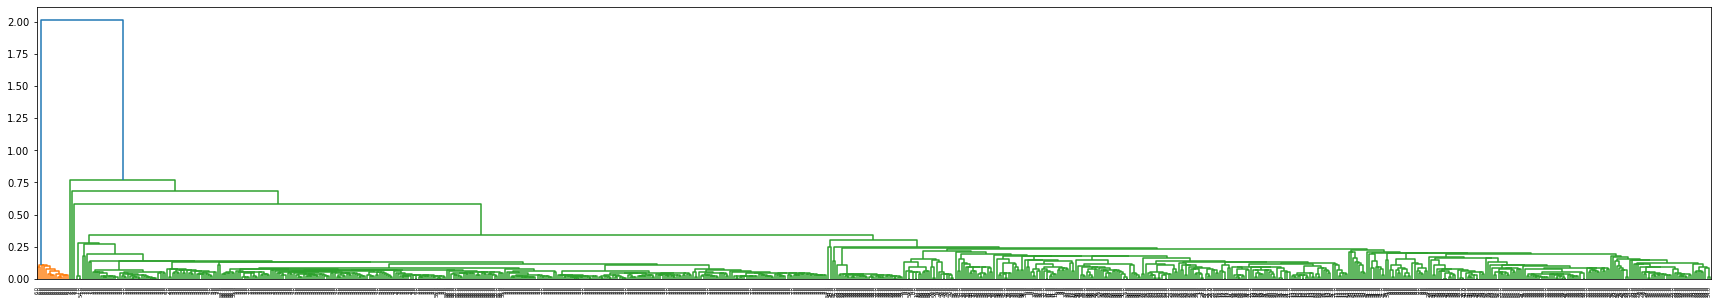

In [4]:
# 开始计算hierarchical clustering并且画图

# 先对上面的alllinedata数据里面的lon、lat做聚类
linked = linkage(alllinedata[['lon', 'lat']], 'single')
fig, ax = plt.subplots(figsize=(30, 5))
hierarchicaldata = dendrogram(linked, orientation='top', labels=alllinedata['linelabel'].values, distance_sort='descending',no_plot=False, p = 5, ax=ax)

In [5]:
# 这里主要是提取上面图的x坐标的标签对应的位置，这个是最困难的部分，本来是打算从hierarchicaldata里面提取的，这个是花了很多时间去尝试，但是没找到，后来还是想把这个图放到matplotlib里面，然后提取ax的x的标签。也就是ax.get_xmajorticklabels()。这个是一个列表，列表里面的是matplotlib的Text对象。这个观察好结构，然后提取就行。
allxlabelposition = ax.get_xmajorticklabels()
labelx = []
labely = []
labeltext = []
for i in allxlabelposition:
    labelx.append(i._x)
    labely.append(i._y)
    labeltext.append(i._text)
allxlabelposition = pd.DataFrame({'ax_x': labelx,
'ax_y': labely, 'labeltext':labeltext})
allxlabelposition['dataindex'] = hierarchicaldata['leaves']
allxlabelposition    # 这个返回的是聚类的标签的所有数据，dataindex是匹配的数据的行的index

,ax_x,ax_y,labeltext,dataindex
0,5,0,6.0,357
1,15,0,6.0,358
2,25,0,6.0,343
3,35,0,6.0,344
4,45,0,6.0,345
...,...,...,...,...
812,8125,0,29.0,478
813,8135,0,29.0,479
814,8145,0,29.0,482
815,8155,0,29.0,483


In [6]:
# 将聚类的结果的x标签位置和原始数据合并，就可以得到一个可以数据框，使用这个数据框，就可以在matplotlib上画出跨子图的连接线。（当然还需要matplotlib的一个小函数，在后面可以看到）
alllinedata['index'] = np.arange(alllinedata.shape[0])
plotdata = alllinedata.merge(allxlabelposition, how='left', left_on='index', right_on='dataindex')
plotdata

,lon,lat,raw_line,linelabel,index,ax_x,ax_y,labeltext,dataindex
0,114.661125,33.617021,0.0,0.0,0,4405,0,0.0,0
1,114.654234,33.559895,0.0,0.0,1,4445,0,0.0,1
2,114.620008,33.562592,0.0,0.0,2,4465,0,0.0,2
3,114.581086,33.562153,0.0,0.0,3,4425,0,0.0,3
4,114.452606,33.552929,0.0,0.0,4,4395,0,0.0,4
...,...,...,...,...,...,...,...,...,...
812,113.905182,33.812265,0.0,59.0,812,4325,0,59.0,812
813,113.888854,33.762816,0.0,59.0,813,4335,0,59.0,813
814,113.871202,33.701237,0.0,59.0,814,4345,0,59.0,814
815,113.882202,33.644564,0.0,59.0,815,4355,0,59.0,815


In [7]:
# plotdata['linelabel'].value_counts().shape

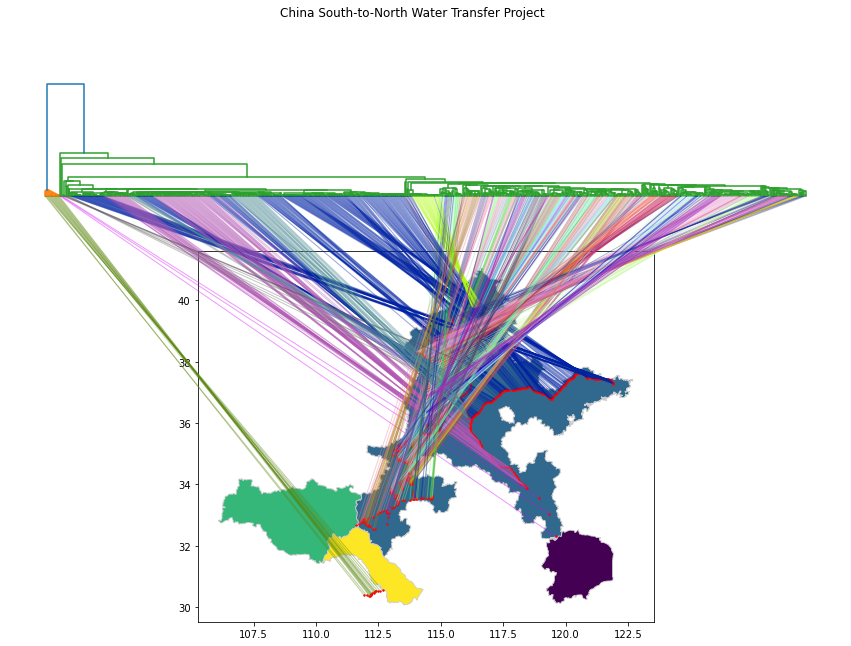

In [8]:
# 创建一个matplotlib对象，这个画板分为上下两个部分，上面的子图用来放聚类图，下面的子图用来放地图。高度比例为1:3
fig, (ax1, ax2) = plt.subplots(figsize=(15,10), gridspec_kw={'height_ratios': [1, 3]}, nrows=2)

# plot 1
for x, y, c in zip(hierarchicaldata['icoord'], hierarchicaldata['dcoord'], hierarchicaldata['color_list']):
    ax1.plot(x, y, c)
ax1.axis('off')

# plot 2
map_df.plot(column='Name', cmap='viridis', ax=ax2, linewidth=0.8, edgecolor='0.8')
ax2.scatter(alllinedata.loc[:, 'lon'], alllinedata.loc[:, 'lat'],s=2, c='red')


# 这部分用来根据plotdata的linelabel对象的种类生成颜色。主要是好看。
# generate color
colortypeunique = plotdata['linelabel'].unique()

number_of_colors = colortypeunique.shape[0]
import random
allcolor = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]



# 这里使用matplotlib的patches的ConnectionPatch 来画跨子图的连接线。
# connect ax1 and ax2
from matplotlib.patches import ConnectionPatch
for i in range(plotdata.shape[0]):
    con = ConnectionPatch(xyA=(plotdata.loc[i,'ax_x'], plotdata.loc[i, 'ax_y']),
    xyB=(plotdata.loc[i,'lon'],plotdata.loc[i,'lat']),
    coordsA=ax1.transData,
    coordsB=ax2.transData,
    color=allcolor[np.where(colortypeunique==plotdata['linelabel'][i])[0][0]], 
    alpha=0.4)
    fig.add_artist(con)

fig.suptitle("China South-to-North Water Transfer Project")

plt.savefig("test.png",dpi=400)